In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
from tqdm.notebook import tqdm
sys.path.append("..")

from phenixml.fragmentation.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.fragments.nn_fragments import FragmentKNN
from phenixml.fragmentation.display import FragmentDisplay
display = FragmentDisplay()

In [4]:
# get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir,max_files=None)

## NN Recall

In [3]:
# Fragment the molecules
fragmenter = MoleculeFragmenter()
fragments = fragmenter(containers)

In [4]:
container = containers[0]
frag_indices = Chem.GetMolFrags(container.rdkit_mol, asMols=False,sanitizeFrags=False)
fragments = [Fragment(container,atom_selection=inds) for inds in frag_indices]

In [5]:
# Featurize the fragments
featurizer = MorganFeaturizer()
features = featurizer.featurize(fragments,nproc=16)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Generate a new query molecule
query_container = MolContainer.from_smiles("CC1(C=C(C(N1[O])(C)C)CSS(=O)(=O)C)C")
query_fragment = query_container.full_fragment
display(query_fragment,show3d=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
# Get a query feature
query_feature = featurizer(query_container)

In [8]:
fragments

In [9]:
%%time
# Set up approximate kNN
knn = FragmentKNN(fragments,features)

ValueError: No hyperplanes of adequate size were found!

In [9]:
# query
nbrs = knn.query(query_feature)

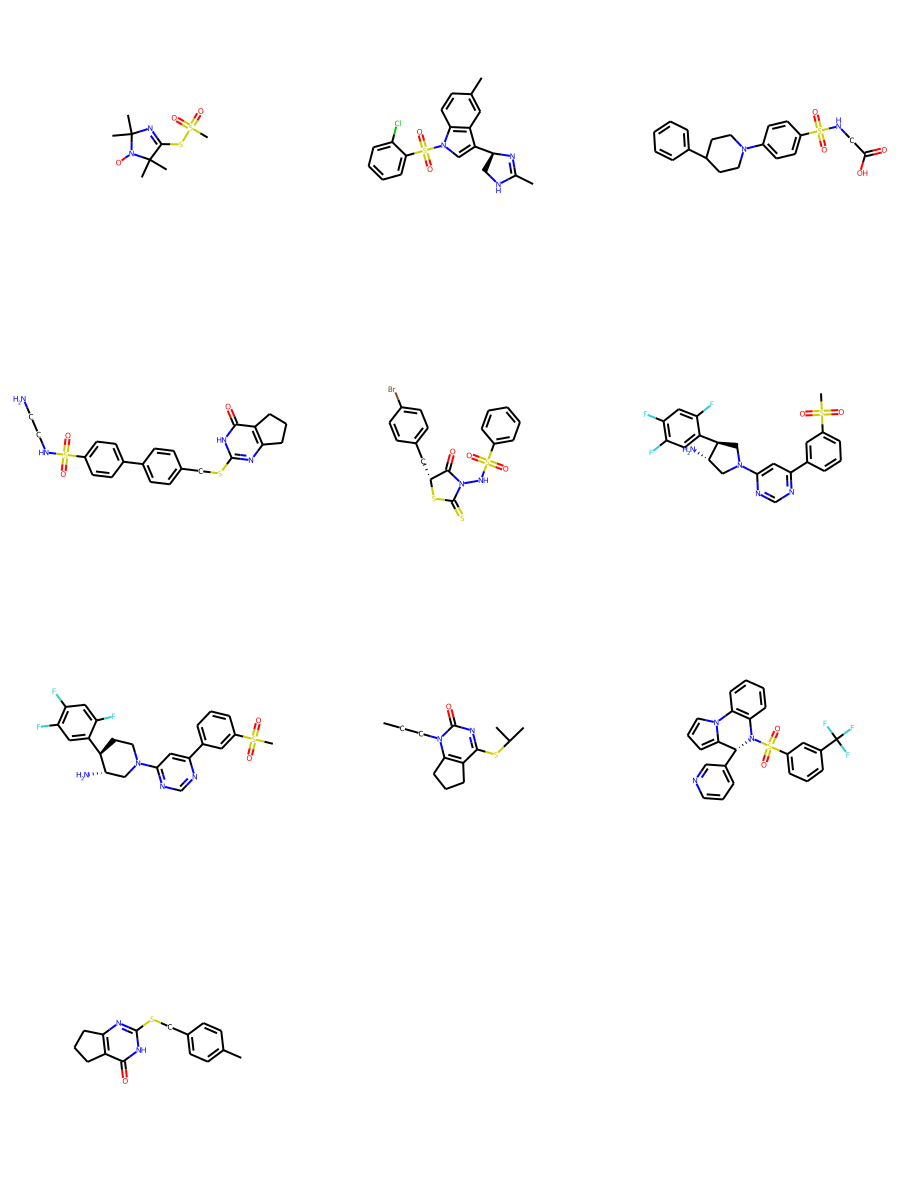

In [10]:
display(nbrs)

# Bonds

In [3]:
# Fragment on bonds
fragmenter = BondFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

NameError: name 'BondFragmenter' is not defined

In [2]:
fragmenter.exclude_elements

NameError: name 'fragmenter' is not defined

In [7]:
%%time
# Featurize the fragments
featurizer = MorganFeaturizer(nBits=1024)
features = featurizer.featurize(fragments,nproc=32)

  0%|          | 0/706263 [00:00<?, ?it/s]

CPU times: user 16.6 s, sys: 20.3 s, total: 36.9 s
Wall time: 42.5 s


In [8]:
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

  0%|          | 0/706263 [00:00<?, ?it/s]

## kNN

## MLP Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [13]:
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)

In [14]:
X,y = features,labels
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [18]:
model = MLPRegressor(hidden_layer_sizes=(512,128))

In [19]:
%%time
_ = model.fit(X_train,y_train)

/net/cci/cschlick/miniconda3/envs/restraintsML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


CPU times: user 13h 44min 32s, sys: 1h 54s, total: 14h 45min 27s
Wall time: 12min 22s


In [21]:
y_pred = model.predict(X_test)

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_geom_eval(a,b,mode="bond",s=0.01):
  

    
  fig, axs = plt.subplots(1,2,figsize=(16,5))
  axs = axs.flatten()
  
  # scatter plot
  ax = axs[0]
  ax.scatter(a,b,s=s)
  #sns.kdeplot(a,b,fill=True)
  if mode == "bond":
    ax.set_xlim(1,1.8)
    ax.set_ylim(1,1.8)
    units = "(Å)"
  elif mode == "angle":
    ax.set_xlim(50,140)
    ax.set_ylim(50,140)
    units = "(deg.)"
  ax.plot([0,200],[0,200],color="black")
  ax.set_xlabel("Reference "+units,fontsize=14)
  ax.set_ylabel("Predicted "+units,fontsize=14)
  
  
  # histogram
  ax = axs[1]
  sns.histplot(a-b,ax=ax,kde=True,stat="density")
  if mode == "bond":
    ax.set_xlim(-3,3)
  elif mode == "angle":
    ax.set_xlim(-20,20)
  ax.set_xlabel("Error (reference-predicted) "+units,fontsize=14)
  ax.set_ylabel("Density estimate",fontsize=14)
  mae = np.abs(a-b).mean()
  ax.set_title("MAE:"+str(mae))


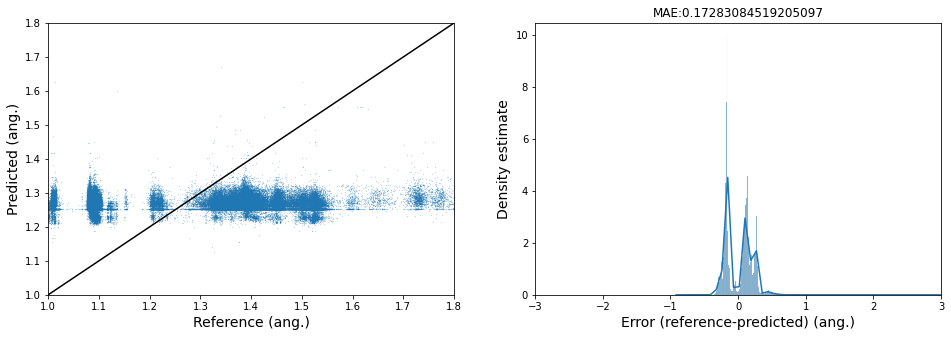

In [25]:
plot_geom_eval(y_test,y_pred)

# Angles

In [ ]:
# Fragment on angles
fragmenter = AngleFragmenter(exclude_elements=["H"])
fragments = fragmenter(containers)

In [ ]:
%%time
# Featurize the fragments
featurizer = MorganFeaturizer(nBits=1024)
features = featurizer.featurize(fragments,nproc=32)

In [ ]:
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

## kNN

## MLP Regression